In [38]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import cv2
import numpy as np
import tensorflow as tf
import skimage.transform
from src.model import Model
from src.data_loader import dataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Plot properties

In [92]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [3]:
# Load train dataset
data = dataLoader(directory='./dataset', dataset_dir='test_cropped',\
                  dataset_name='test.txt', max_steps=6, mode='Test')

### ----------------------------------- Digit Detection -----------------------------------

In [4]:
# Change if needed
print_every      = 2000
batch_size       = 1
n_iters          = data.max_length
pretrained_model = './model/lstm2/model-650'
ground_attention_upsample = (64, 64)

In [5]:
# Load Model
model = Model(dim_feature=[196, 128], dim_hidden=128, n_time_step=6,\
              alpha_c=1.0, image_height=64, image_width=64, mode='test')
# Build model for inference
pred_bboxs_, alpha_list_ = model.build_test_model()

CNN build model sucess!


In [6]:
## Run FeedForward

# Collect predictions from runs for viz
vis_images  = []
attn_images = []
pred_bboxes = []
grnd_bboxes = []

# Test Data Loader
test_gen = data.gen_data_batch(batch_size)

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if pretrained_model is not None:
        print("Start testing with pretrained Model..")
        saver.restore(sess, pretrained_model)
    else:
        print("Start testing with Model with random weights...")

    for i in range(n_iters):
        image_batch, image_batch_norm, grd_bboxes_batch, _= next(test_gen)
        feed_dict = {model.images: image_batch_norm,
                     model.drop_prob: 1.0}
        prediction_bboxes, prediction_alpha = sess.run([pred_bboxs_, alpha_list_], feed_dict)
        
        vis_images.append(image_batch)
        attn_images.append(prediction_alpha)
        pred_bboxes.append(prediction_bboxes)
        grnd_bboxes.append(grd_bboxes_batch)
        
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close session
sess.close()

Start testing with pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/lstm2/model-650
Inference Completion..{0/13068}
Inference Completion..{2000/13068}
Inference Completion..{4000/13068}
Inference Completion..{6000/13068}
Inference Completion..{8000/13068}
Inference Completion..{10000/13068}
Inference Completion..{12000/13068}
Inference Completion..{13068/13068}
Completed!


In [7]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))

13068
13068
13068
13068


In [94]:
## Upscale attention mask
upscaled_attn_images = []
for k in range(0, n_iters, 200):
    sample_attention_res_interm = []
    for K in range(6):
        sample_attention_res = skimage.transform.pyramid_expand(attn_images[k][K][0][:, :, 0], upscale=4.55, sigma=1)
        sample_attention_res_interm.append(sample_attention_res)
    
    upscaled_attn_images.append(sample_attention_res_interm)

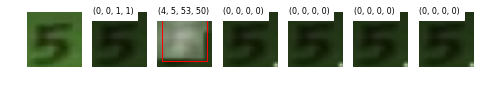

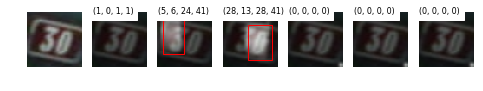

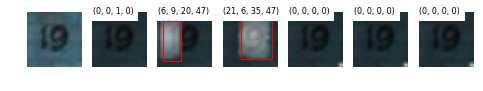

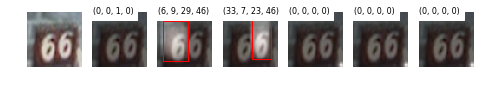

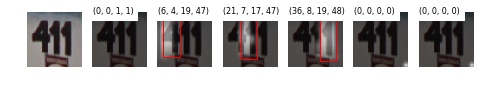

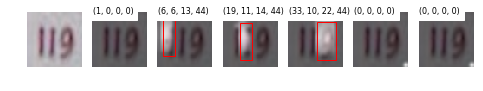

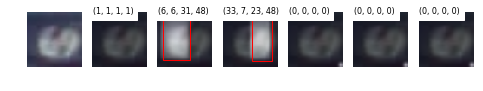

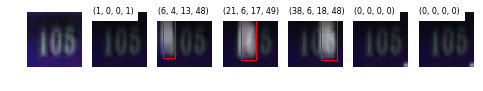

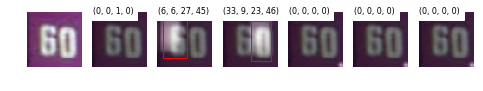

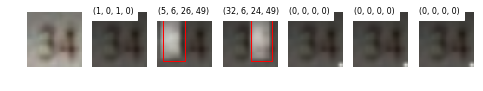

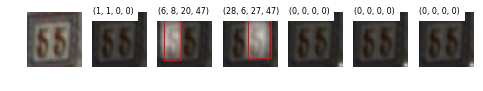

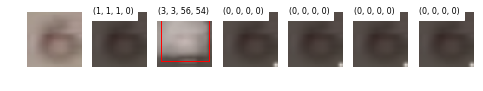

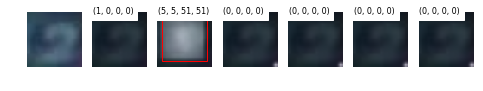

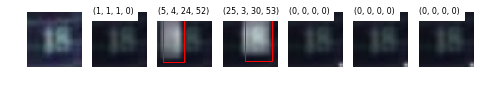

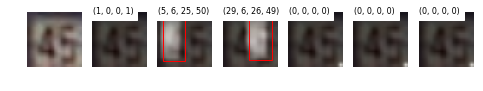

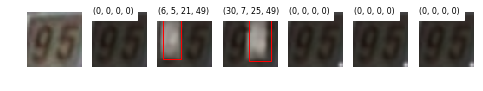

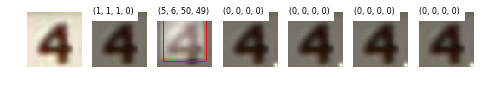

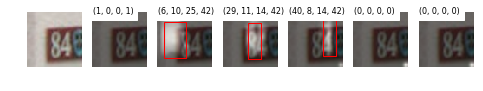

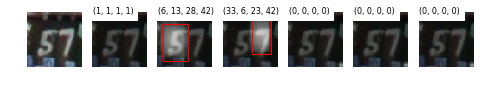

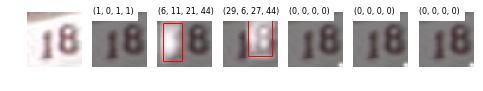

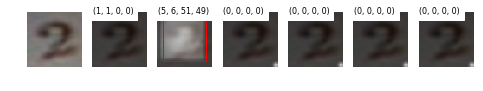

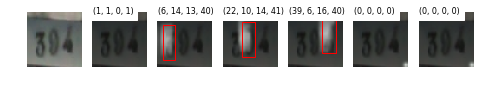

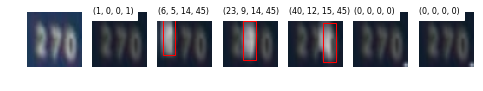

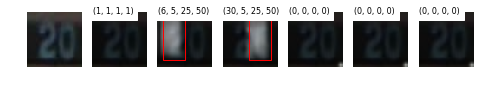

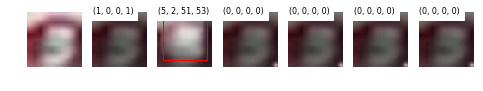

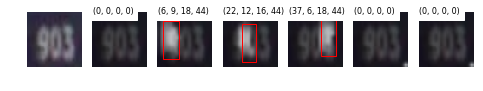

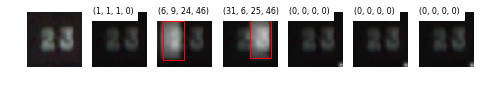

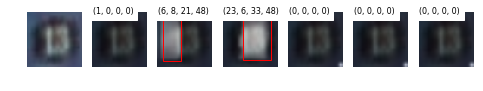

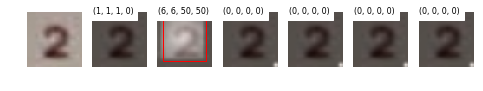

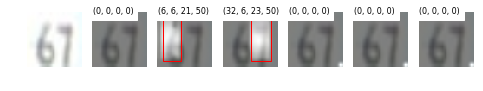

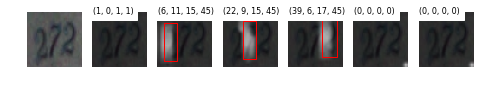

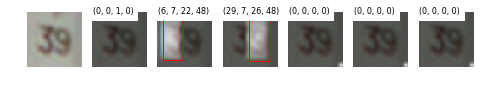

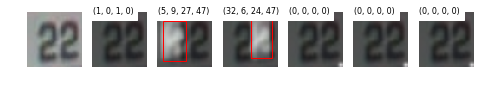

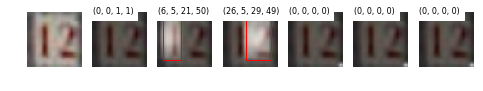

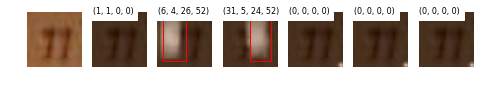

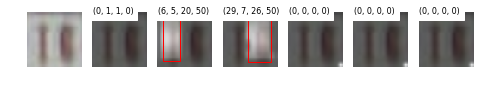

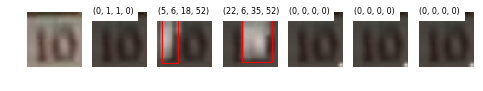

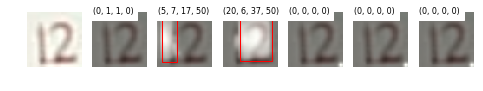

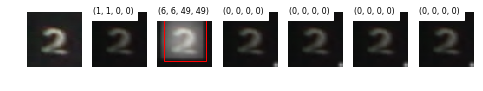

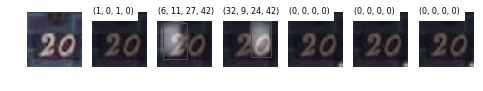

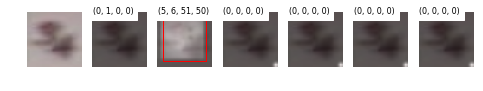

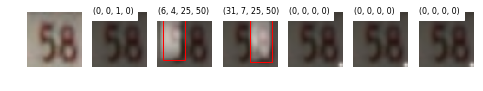

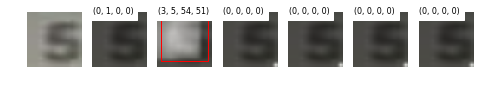

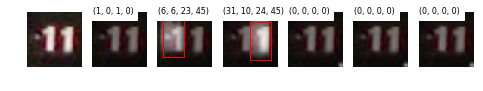

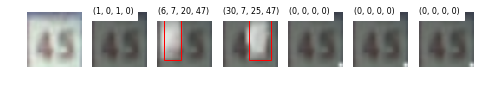

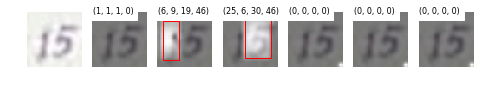

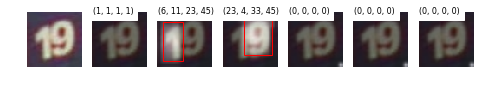

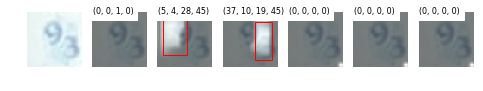

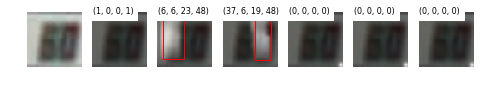

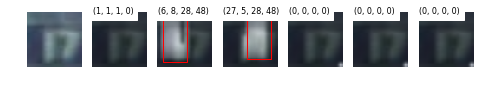

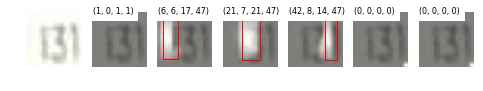

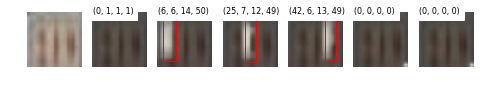

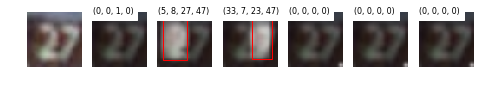

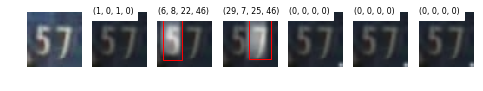

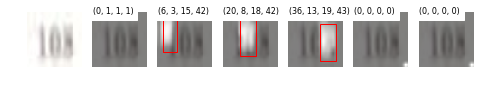

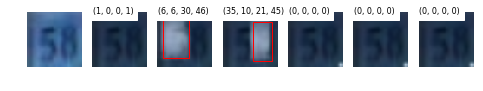

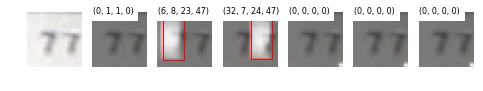

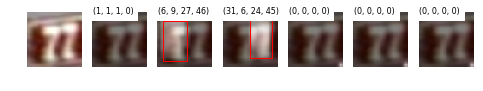

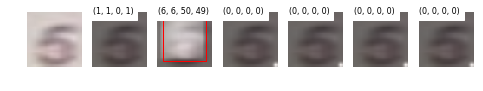

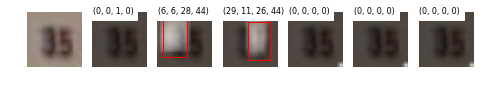

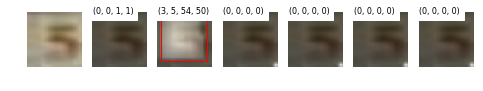

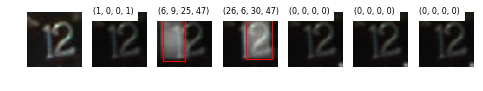

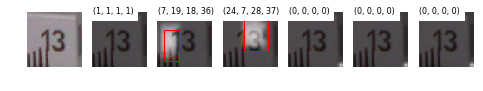

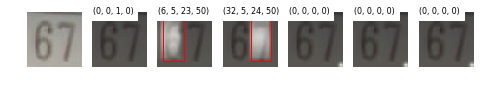

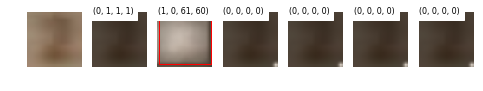

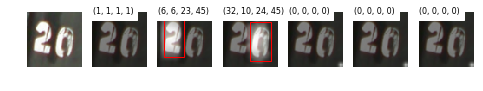

In [95]:
count = 0
for t in range(0, n_iters, 200):
    # Plot original image
    fig,ax = plt.subplots(1, 7)
    ax[0].imshow((vis_images[t][0]))
    ax[0].axis('off')
    for T in range(6):
        ax[T+1].imshow((vis_images[t][0]))
        ax[T+1].imshow(upscaled_attn_images[count][T], alpha=0.5)
        sample_left  = pred_bboxes[t][T][0][0]
        sample_top   = pred_bboxes[t][T][0][1]
        sample_width = pred_bboxes[t][T][0][2]
        sample_heigt = pred_bboxes[t][T][0][3]

        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]
        
        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        #rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  
        
        ax[T+1].text(0, 1, (int(sample_left), int(sample_top), int(sample_width), int(sample_heigt)), color='black', backgroundcolor='white', fontsize=8)
        ax[T+1].add_patch(rect1)
        #ax[T+1].add_patch(rect2)
        ax[T+1].axis('off')
    
    plt.show()
    count += 1

### ------------------------------ Digit Classification -----------------------------------

In [106]:
viz = True
max_steps = 6
pretrained_clfy_model='./model/clsfy2/model-392'

In [107]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)  # set default size of plots

In [113]:
def bbox_threshold(left, top, width, height):
    valid_box = False
    # If the threshold box is less than 10
    if width * height < 20:
        valid_box = False
    elif left == 0 and top == 0 and\
         width == 0 and height == 0:
        valid_box = False
    else:
        valid_box = True

    return valid_box

In [114]:
del Clfy_Model

In [115]:
from src.baseline_classify import Model as Clfy_Model

In [116]:
# Reset graph
tf.reset_default_graph()
# Load
clfy_model = Clfy_Model(image_height=16, image_width=16, mode='test')
# Predictions
_, predictions  = clfy_model.build_test_model()

Classification build model sucess!


Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy2/model-392


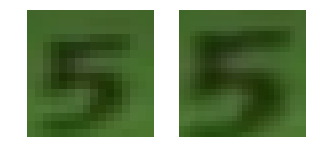

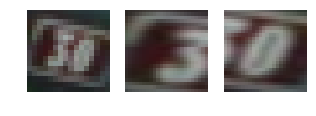

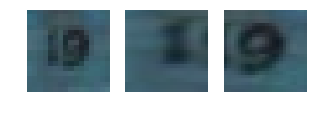

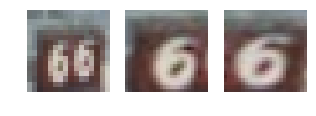

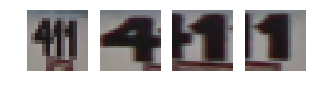

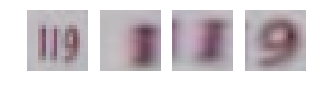

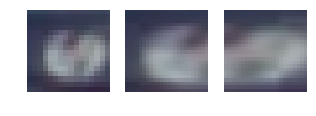

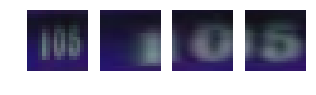

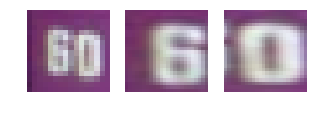

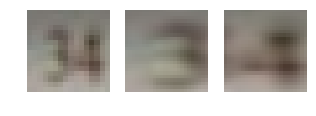

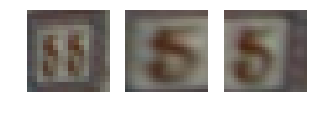

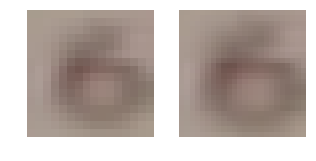

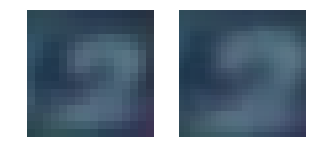

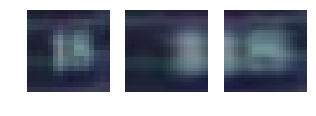

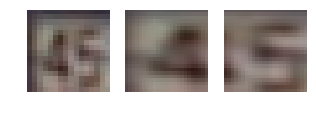

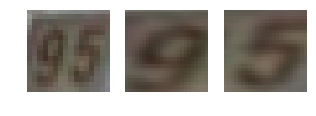

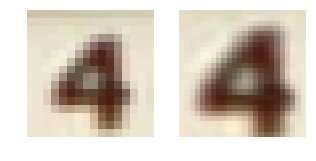

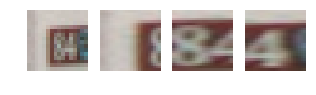

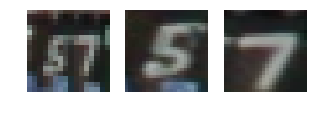

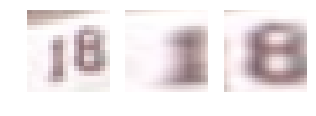

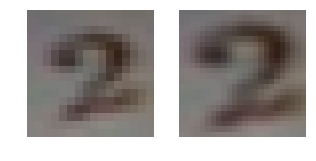

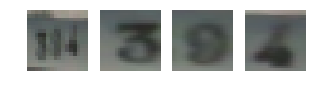

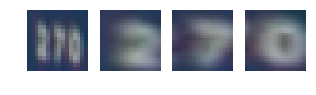

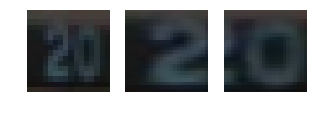

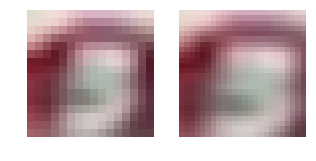

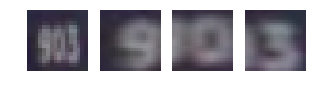

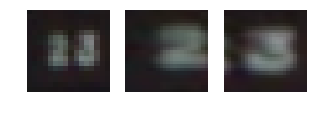

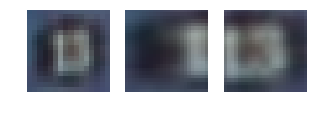

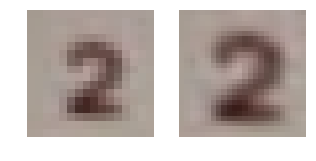

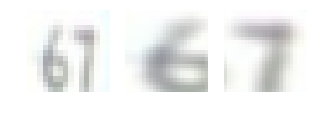

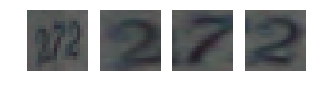

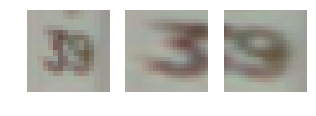

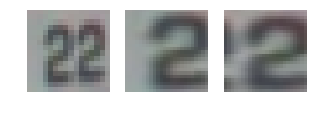

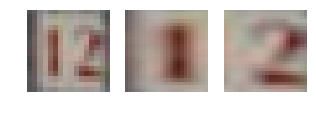

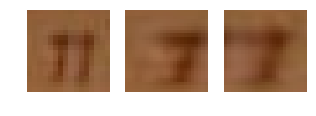

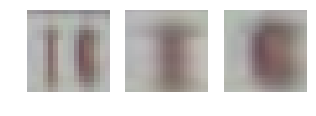

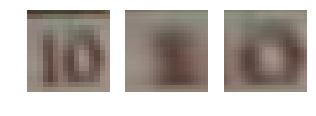

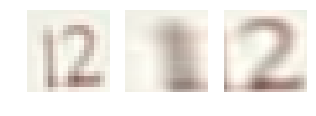

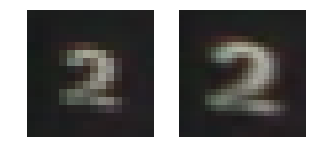

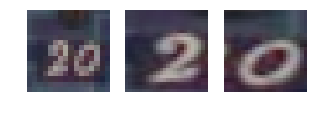

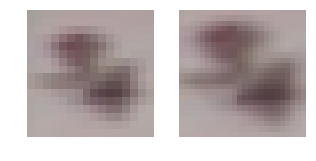

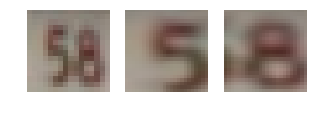

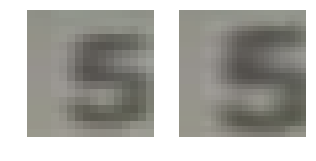

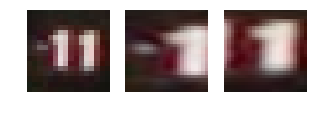

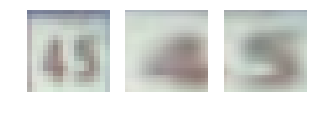

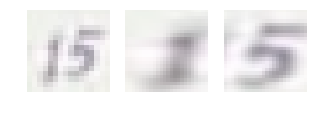

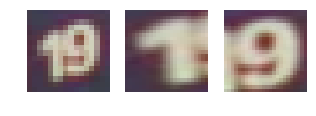

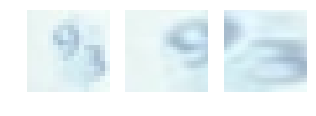

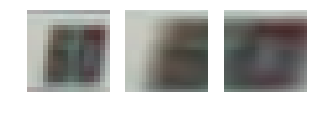

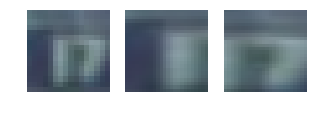

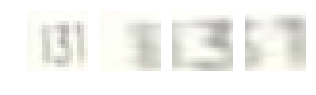

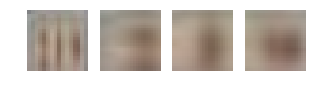

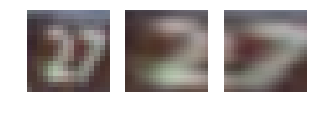

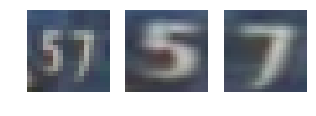

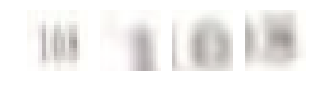

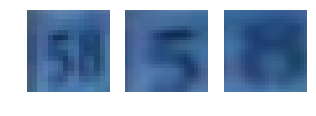

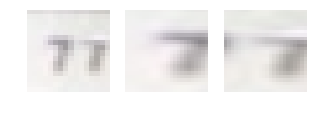

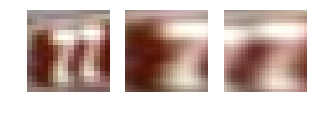

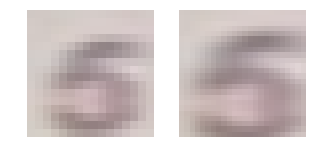

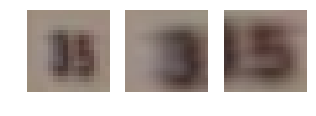

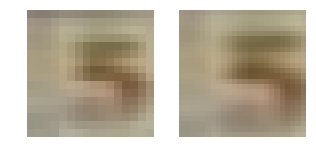

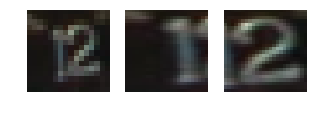

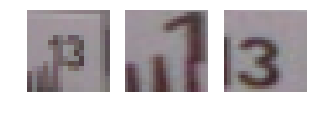

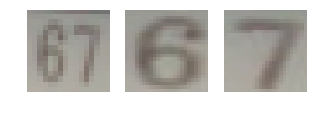

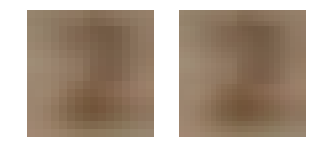

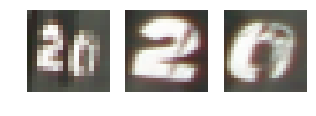

In [119]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    # To load
    saver = tf.train.Saver()
    # Load pretrained model
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    # Run predictions
    for t in range(0, n_iters, 200):
        # Get image
        test_image = vis_images[t][0]
        # Valid predictions
        valid_pred     = []
        valid_pred_img = []
        num_valid_pred = 0
        # Loop through steps
        for T in range(max_steps):
            sample_left  = int(pred_bboxes[t][T][0][0])
            sample_top   = int(pred_bboxes[t][T][0][1])
            sample_width = int(pred_bboxes[t][T][0][2]) + 3
            sample_heigt = int(pred_bboxes[t][T][0][3]) + 4
            
            vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
                                      width=sample_width, height=sample_heigt)
            if vld_bbox:
                extract_img = test_image[sample_top:sample_top+sample_heigt, sample_left:sample_left+sample_width, :]
                extract_img = cv2.resize(extract_img, (24, 24), interpolation = cv2.INTER_LINEAR)
                #extract_img_norm = extract_img/127.5 - 1.0
                #extract_img_norm = np.expand_dims(extract_img_norm, axis=0) # [1, H, W, C]
                # Predictions
                #feed_dict = {clfy_model.images: extract_img_norm,
                #             clfy_model.drop_prob: 1.0}
                #pred = sess.run(predictions, feed_dict)
                #valid_pred.append(pred)
                valid_pred_img.append(extract_img)        
                num_valid_pred += 1
            
        if viz:
            # Plot original image
            fig,ax = plt.subplots(1, num_valid_pred+1)
            test_img = cv2.resize(test_image, (16, 16), interpolation = cv2.INTER_AREA)
            ax[0].imshow(test_img)
            ax[0].axis('off')     
            for tT in range(num_valid_pred):
                ax[tT+1].imshow(valid_pred_img[tT])
                #ax[tT+1].text(0, 1, pred[0], color='black', backgroundcolor='white', fontsize=8)
                ax[tT+1].axis('off')     
            plt.show()